<a href="https://colab.research.google.com/github/christee8/lsa-model/blob/master/tasks/cs_NER/Multilingual_BERT_cs_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!pip3 install transformers

     |████████████████████████████████| 778kB 4.5MB/s 
     |████████████████████████████████| 890kB 19.3MB/s 
     |████████████████████████████████| 1.1MB 16.1MB/s 
     |████████████████████████████████| 3.0MB 43.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a7c44331df53068981e91d1202b0d798d3aa8ad3363c8259f532060183757312
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
!pip3 install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=b282a8a08e3710bdd99166112bbfb648f2ccd349406779a7c6f96f0e3af89c28
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [4]:
# Electra cs pytorch model
!cp -r /gdrive/'My Drive'/question_answering/models/electra_cs/model_base .

In [5]:
# NER dataset
!cp -r /gdrive/'My Drive'/question_answering/tasks/cs_NER/dataset/json_format .

In [6]:
import json
import torch
import tensorflow as tf
from transformers import BertForTokenClassification, ElectraConfig, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
from tokenizers import BertWordPieceTokenizer
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
# https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/
# http://mccormickml.com/2019/07/22/BERT-fine-tuning/
# https://github.com/abhishekkrthakur/bert-entity-extraction

In [8]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [9]:
# Load datasets
train_data_file = open("json_format/named_ent_train_brief.json", "r")
train_data = json.load(train_data_file, encoding="UTF-16")
print(train_data['sentence 0'])

test_data_file = open("json_format/named_ent_dtest_brief.json", "r")
# test_data_file = open("json_format/named_ent_etest_brief.json", "r")
test_data = json.load(test_data_file, encoding="UTF-16")
print(test_data['sentence 0'])

[{'word': 'Jste', 'tags': []}, {'word': 'světa', 'tags': []}, {'word': 'znalý', 'tags': []}, {'word': 'muž', 'tags': []}, {'word': 'a', 'tags': []}, {'word': 'víte', 'tags': []}, {'word': 'stejně', 'tags': []}, {'word': 'dobře', 'tags': []}, {'word': 'jako', 'tags': []}, {'word': 'já', 'tags': []}, {'word': ',', 'tags': []}, {'word': 'že', 'tags': []}, {'word': 'souvislost', 'tags': []}, {'word': 'mezi', 'tags': []}, {'word': 'současnými', 'tags': []}, {'word': 'krutostmi', 'tags': []}, {'word': 'v', 'tags': []}, {'word': 'Jihovýchodní', 'tags': []}, {'word': 'Asii', 'tags': ['g']}, {'word': 'a', 'tags': []}, {'word': 'tou', 'tags': []}, {'word': 'novou', 'tags': []}, {'word': 'bankovní', 'tags': []}, {'word': 'pobočkou', 'tags': []}, {'word': 'hned', 'tags': []}, {'word': 'vedle', 'tags': []}, {'word': 'obchoďáku', 'tags': []}, {'word': 'Zátoka', 'tags': ['i']}, {'word': 'je', 'tags': []}, {'word': 'přímá', 'tags': []}, {'word': 'a', 'tags': []}, {'word': 'bezprostřední', 'tags': []},

In [10]:
class TagIdGetter:
  def __init__(self):
    self.tags_to_ids = {"PAD": 0}
    self.cur_id = 1
    self.ids_to_tags = ["PAD"]

  def get_id(self, tag):
    if tag not in self.tags_to_ids:
      self.tags_to_ids[tag] = self.cur_id
      self.ids_to_tags.append(tag)
      self.cur_id += 1
    
    return self.tags_to_ids[tag]

  def get_tag(self, id):
    return self.ids_to_tags[id]

  def get_tag_cnt(self):
    return self.cur_id

In [11]:
tag_id_getter = TagIdGetter()

In [12]:
def get_sent_data(data, tag_id_getter):
  sent_data = []

  for sent in data:
    words = []
    tags = []

    for word_data in data[sent]:
      words.append(word_data['word'])

      # Not all tags, just the first
      if word_data['tags']:
        tag = word_data['tags'][0]
      else:
        tag = "NO_TAG"
      
      tags.append(tag_id_getter.get_id(tag))
      
    sent_data.append({"words": words, "tags": tags})

  return sent_data

In [13]:
train_sent_data = get_sent_data(data=train_data, tag_id_getter=tag_id_getter)
test_sent_data = get_sent_data(data=test_data, tag_id_getter=tag_id_getter)

print(train_sent_data[:3])
print(test_sent_data[0])

print("Number of train sentences:", len(train_sent_data))
print("Number of test sentences:", len(test_sent_data))

[{'words': ['Jste', 'světa', 'znalý', 'muž', 'a', 'víte', 'stejně', 'dobře', 'jako', 'já', ',', 'že', 'souvislost', 'mezi', 'současnými', 'krutostmi', 'v', 'Jihovýchodní', 'Asii', 'a', 'tou', 'novou', 'bankovní', 'pobočkou', 'hned', 'vedle', 'obchoďáku', 'Zátoka', 'je', 'přímá', 'a', 'bezprostřední', ';'], 'tags': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1]}, {'words': ['byl', 'z', 'toho', 'už', 'vzteklý', 'jak', 'uvázaný', 'pes', ',', 'protože', 'zájemci', 'o', 'hodiny', 'mu', 'úplně', 'narušili', 'jeho', 'denní', 'režim', 'a', 'on', 'si', 'nemohl', 'po', 'obědě', 'ani', 'zdřímnout', '.'], 'tags': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, {'words': ['I', 's', 'Dubenkou', ',', 'na', 'kterou', 'U', 'tygra', 'teď', 'myslím', '.', '.', '.'], 'tags': [1, 1, 4, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1]}]
{'words': ['Vede', 'ji', 'žena', ',', 'jmenuje', 'se', 'Ann', 'Suba', '.'], 'tags': [1, 1, 1, 1, 1, 

In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", do_lower_case=False)

In [15]:
text = "Již od počátku vědy si mnoho lidí klade otázku, zda může cestovat do minulosti a změnit ji, či cestovat do budoucnosti a vyhnout se jejím následkům.[zdroj?] Přestože až do začátku 20. století bylo cestování v čase považováno za nemožné, fyzik Albert Einstein pomocí speciální teorie relativity ukázal, že do budoucnosti v jistém smyslu cestovat lze. Podle této teorie, pokud se jakékoliv těleso přiblíží rychlosti světla, čas se pro něj z hlediska ostatních zpomalí, takže vlastně cestuje do budoucnosti. Stejného efektu lze dle obecné teorie relativity dosáhnout pobytem v silném gravitačním poli, například poblíž černé díry. Nicméně žádný z těchto způsobů neumožňuje se vrátit do výchozí doby, cesta je jednosměrná."
tokenizer.tokenize(text)

['Ji',
 '##ž',
 'od',
 'počátku',
 'v',
 '##ě',
 '##dy',
 'si',
 'mnoho',
 'lidí',
 'kl',
 '##ade',
 'ot',
 '##áz',
 '##ku',
 ',',
 'z',
 '##da',
 'může',
 'ces',
 '##tov',
 '##at',
 'do',
 'minulosti',
 'a',
 'zm',
 '##ěn',
 '##it',
 'ji',
 ',',
 'či',
 'ces',
 '##tov',
 '##at',
 'do',
 'bu',
 '##dou',
 '##c',
 '##nosti',
 'a',
 'v',
 '##y',
 '##hn',
 '##out',
 'se',
 'jejím',
 'ná',
 '##sle',
 '##d',
 '##ků',
 '##m',
 '.',
 '[',
 'z',
 '##droj',
 '?',
 ']',
 'P',
 '##ře',
 '##sto',
 '##že',
 'až',
 'do',
 'začátku',
 '20',
 '.',
 'století',
 'bylo',
 'ces',
 '##tov',
 '##ání',
 'v',
 'čase',
 'po',
 '##va',
 '##žo',
 '##váno',
 'za',
 'nem',
 '##o',
 '##žné',
 ',',
 'f',
 '##y',
 '##zik',
 'Albert',
 'Einstein',
 'pomocí',
 'sp',
 '##eci',
 '##ální',
 'teorie',
 'relativ',
 '##ity',
 'uk',
 '##ázal',
 ',',
 'že',
 'do',
 'bu',
 '##dou',
 '##c',
 '##nosti',
 'v',
 'jis',
 '##tém',
 'sm',
 '##yslu',
 'ces',
 '##tov',
 '##at',
 'lze',
 '.',
 'Podle',
 'této',
 'teorie',
 ',',
 'pokud',


In [16]:
def get_max_seq_len(sent_data):
  max_len = 0

  for sent in sent_data:
    sent_len = 0
    
    for word in sent["words"]:
      input_ids = tokenizer.encode(word, add_special_tokens=False)
      # tokens = tokenizer.convert_ids_to_tokens(input_ids)
      # print(tokens)
      sent_len += len(input_ids)
    
    max_len = max(max_len, sent_len)

  # 2 special tokens, CLS and SEP
  return max_len + 2

In [17]:
# Max sequence length
MAX_SEQ_LEN = max(get_max_seq_len(sent_data=train_sent_data), get_max_seq_len(sent_data=test_sent_data))
print(MAX_SEQ_LEN)

241


In [18]:
def prepare_model_input(sent_data, max_seq_len, tag_id_getter):
  input_ids = []
  tags = []
  attention_masks = []

  for sent in sent_data:
    sent_input_ids = []
    sent_tags = []

    for word_data in zip(sent["words"], sent["tags"]):
      word = word_data[0]
      tag = word_data[1]

      # Split word into tokens
      word_input_ids = tokenizer.encode(word, add_special_tokens=False)
      word_input_len = len(word_input_ids)

      # Add tokens and associated tag to sentence tokens and tags
      sent_input_ids.extend(word_input_ids)
      sent_tags.extend([tag] * word_input_len)

    # Add special tokens
    sent_input_ids = [101] + sent_input_ids + [102]
    sent_tags = [0] + sent_tags + [0]

    # Create attention mask
    sent_attention_mask = [1] * len(sent_input_ids)

    # Padding
    padding_len = max_seq_len - len(sent_input_ids)
    sent_input_ids = sent_input_ids + ([0] * padding_len)
    sent_tags = sent_tags + ([tag_id_getter.get_id("PAD")] * padding_len)
    sent_attention_mask = sent_attention_mask + ([0] * padding_len)

    # Append to lists for all sentences
    input_ids.append(torch.tensor(sent_input_ids, dtype=torch.long))
    tags.append(torch.tensor(sent_tags, dtype=torch.long))
    attention_masks.append(torch.tensor(sent_attention_mask, dtype=torch.long))

  # Convert the lists of tensors into tensors of tensors
  input_ids = torch.stack(input_ids, dim=0)
  tags = torch.stack(tags, dim=0)
  attention_masks = torch.stack(attention_masks, dim=0)

  return {
      "input_ids": input_ids,
      "tags": tags,
      "attention_masks": attention_masks,
  }

In [19]:
train_input = prepare_model_input(sent_data=train_sent_data, max_seq_len=MAX_SEQ_LEN, tag_id_getter=tag_id_getter)
test_input = prepare_model_input(sent_data=test_sent_data, max_seq_len=MAX_SEQ_LEN, tag_id_getter=tag_id_getter)

In [20]:
BATCH_SIZE = 32

train_dataset = TensorDataset(train_input["input_ids"], train_input["attention_masks"], train_input["tags"])

# Training dataloader, takes batches in random order
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = BATCH_SIZE
        )

test_dataset = TensorDataset(test_input["input_ids"], test_input["attention_masks"], test_input["tags"])

# Test dataloader, takes batches sequentially
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = BATCH_SIZE
        )

In [21]:
NUM_TAGS = tag_id_getter.get_tag_cnt()
print("Num of different tags:", NUM_TAGS)

Num of different tags: 11


In [22]:
# Initialize model
model = BertForTokenClassification.from_pretrained(
   "bert-base-multilingual-cased",
    num_labels = NUM_TAGS,
    output_attentions = False,
    output_hidden_states = False
  )

model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [23]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

In [24]:
# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [25]:
# Learning rate scheduler
NUM_EPOCHS = 3
MAX_GRAD_NORM = 1.0

# Total number of training steps (number of batches * number of epochs)
total_steps = len(train_dataloader) * NUM_EPOCHS

# Create scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Default value in run_glue.py
    num_training_steps=total_steps
)

In [26]:
def predict_tags(sentence, tokenizer, model, tag_id_getter):
  # Tokenize sentence
  tokenized_sentence = tokenizer.encode(sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()

  # Run through model
  with torch.no_grad():
    output = model(input_ids)

  tag_ids = np.argmax(output[0].to('cpu').numpy(), axis=2)
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  
  words, predicted_tags = [], []

  for token, tag_id in zip(tokens, tag_ids[0]):
      if token.startswith("##"):
          words[-1] = words[-1] + token[2:]
      else:
          predicted_tags.append(tag_id_getter.get_tag(tag_id))
          words.append(token)

  for word, tag in zip(words, predicted_tags):
    print("{}\t{}".format(tag, word))

In [27]:
def train_and_validate(gpu_device, model, train_dataloader, test_dataloader, num_epochs=3, max_grad_norm=1.0):
  # Average train and validation losses after each epoch
  train_loss_vals, validation_loss_vals = [], []

  # For each epoch
  for _ in trange(num_epochs, desc="Epoch"):
    # Put the model into training mode
    model.train()

    # Reset the total train loss for this epoch
    total_train_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # Add batch to gpu
        batch = tuple(b.to(gpu_device) for b in batch)
        b_input_ids, b_attention_mask, b_labels = batch
        
        # Clear previously calculated gradients
        model.zero_grad()
        
        # Forward pass (get the loss)
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_attention_mask, labels=b_labels)
        b_loss = outputs[0]

        # Backward pass to calculate the gradients
        b_loss.backward()

        # Save the loss
        total_train_loss += b_loss.item()

        # Clip the norm of the gradient (to help prevent the "exploding gradients" problem)
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

        # Update parameters
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate and store the average train loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    train_loss_vals.append(avg_train_loss)

    # Put the model into validation mode
    model.eval()

    # Reset the total validation loss and accuracy for this epoch
    total_validation_loss, total_validation_accuracy = 0, 0
    
    predictions, true_labels = [], []
    
    # Validation loop
    for batch in test_dataloader:
        batch = tuple(b.to(gpu_device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients (saving memory and speeding up validation)
        with torch.no_grad():
            # Forward pass (calculate logit predictions)
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        labels = b_labels.to('cpu').numpy()

        # Save the loss, predictions and true labels
        total_validation_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(labels)

    # Compute validation loss
    avg_validation_loss = total_validation_loss / len(test_dataloader)
    print("Average validation loss: {}".format(avg_validation_loss))
    validation_loss_vals.append(avg_validation_loss)

    # Get true and predicted tags
    predicted_tags = [tag_id_getter.get_tag(pred_item) for pred_row, true_row in zip(predictions, true_labels)
                                                for pred_item, true_item in zip(pred_row, true_row) if tag_id_getter.get_tag(true_item) != "PAD"]

    true_tags = [tag_id_getter.get_tag(true_item) for pred_row, true_row in zip(predictions, true_labels)
                                                for pred_item, true_item in zip(pred_row, true_row) if tag_id_getter.get_tag(true_item) != "PAD"]

    # Compute prediction accuracy
    print("Validation Accuracy: {}".format(accuracy_score(predicted_tags, true_tags)))
    print("Validation F1-Score: {}".format(f1_score(predicted_tags, true_tags)))

  return (train_loss_vals, validation_loss_vals)


In [28]:
train_loss_vals, validation_loss_vals = train_and_validate(gpu_device=device, model=model, train_dataloader=train_dataloader,
                                                    test_dataloader=test_dataloader, num_epochs=NUM_EPOCHS, max_grad_norm=MAX_GRAD_NORM)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.2701045824670129
Average validation loss: 0.13071146311944928
Validation Accuracy: 0.9573129573129573


Epoch:  33%|███▎      | 1/3 [05:10<10:20, 310.32s/it]

Validation F1-Score: 0.7973033707865169
Average train loss: 0.11082613483071327
Average validation loss: 0.11742618557964933
Validation Accuracy: 0.9626859626859627


Epoch:  67%|██████▋   | 2/3 [10:23<05:11, 311.19s/it]

Validation F1-Score: 0.8341528833258828
Average train loss: 0.06900804572221306
Average validation loss: 0.10678589260526772
Validation Accuracy: 0.965034965034965


Epoch: 100%|██████████| 3/3 [15:36<00:00, 312.12s/it]

Validation F1-Score: 0.8324918658139795


In [29]:
def plot_losses(train_loss_vals, validation_loss_vals):
  %matplotlib inline

  # Plot styling from seaborn
  sns.set(style='darkgrid')

  # Set plot size and font size
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve
  plt.plot(train_loss_vals, 'b-o', label="training loss")
  plt.plot(validation_loss_vals, 'r-o', label="validation loss")

  # Label the plot
  plt.title("Learning curve")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.show()

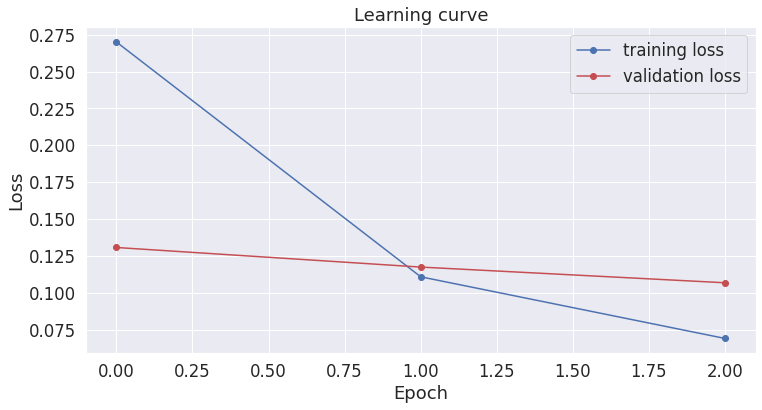

In [30]:
plot_losses(train_loss_vals=train_loss_vals, validation_loss_vals=validation_loss_vals)

In [31]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [32]:
predict_tags("Úřad vlády potvrdil, že Pompeo během pobytu v Česku kromě Prahy navštíví také Plzeň. „S jeho účastí se původně počítalo už v květnu u příležitosti 75 .výročí osvobození Plzně americkou armádou, návštěva ale byla kvůli koronaviru zrušena,“ uvedl úřad", tokenizer=tokenizer, model=model, tag_id_getter=tag_id_getter)

PAD	[CLS]
NO_TAG	Úřad
NO_TAG	vlády
NO_TAG	potvrdil
NO_TAG	,
NO_TAG	že
p	Pompeo
NO_TAG	během
NO_TAG	pobytu
NO_TAG	v
g	Česku
NO_TAG	kromě
g	Prahy
NO_TAG	navštíví
NO_TAG	také
g	Plzeň
NO_TAG	.
NO_TAG	„
NO_TAG	S
NO_TAG	jeho
NO_TAG	účastí
NO_TAG	se
NO_TAG	původně
NO_TAG	počítalo
NO_TAG	už
NO_TAG	v
t	květnu
NO_TAG	u
NO_TAG	příležitosti
n	75
n	.
NO_TAG	výročí
NO_TAG	osvobození
g	Plzně
NO_TAG	americkou
NO_TAG	armádou
NO_TAG	,
NO_TAG	návštěva
NO_TAG	ale
NO_TAG	byla
NO_TAG	kvůli
NO_TAG	koronaviru
NO_TAG	zrušena
NO_TAG	,
NO_TAG	[UNK]
NO_TAG	uvedl
NO_TAG	úřad
PAD	[SEP]


In [33]:
predict_tags("Petříček následně uvedl, že bude s americkým protějškem jednat v úterý právě v Plzni. „V úterý 11. srpna se s ministrem Pompeem setkám v Plzni, kde si mimo jiné připomeneme 75. výročí konce druhé světové války u památníku Díky, Ameriko!“ napsal na twitteru.", tokenizer=tokenizer, model=model, tag_id_getter=tag_id_getter)

PAD	[CLS]
p	Petříček
NO_TAG	následně
NO_TAG	uvedl
NO_TAG	,
NO_TAG	že
NO_TAG	bude
NO_TAG	s
NO_TAG	americkým
NO_TAG	protějškem
NO_TAG	jednat
NO_TAG	v
NO_TAG	úterý
NO_TAG	právě
NO_TAG	v
g	Plzni
NO_TAG	.
NO_TAG	„
NO_TAG	V
NO_TAG	úterý
t	11
t	.
t	srpna
NO_TAG	se
NO_TAG	s
NO_TAG	ministrem
p	Pompeem
NO_TAG	setkám
NO_TAG	v
g	Plzni
NO_TAG	,
NO_TAG	kde
NO_TAG	si
NO_TAG	mimo
NO_TAG	jiné
NO_TAG	připomeneme
n	75
n	.
NO_TAG	výročí
NO_TAG	konce
NO_TAG	druhé
NO_TAG	světové
NO_TAG	války
NO_TAG	u
NO_TAG	památníku
o	Díky
o	,
o	Ameriko
o	!
NO_TAG	[UNK]
NO_TAG	napsal
NO_TAG	na
NO_TAG	twitteru
NO_TAG	.
PAD	[SEP]
